In [1]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/ai4eng.v1/main/content/init.py
import init; init.init(force_download=False); init.get_weblink()

replicating local resources


In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '.'
!chmod 600 ./kaggle.json
!kaggle competitions download -c udea-ai-4-eng-20251-pruebas-saber-pro-colombia

  0% 0.00/29.9M [00:00<?, ?B/s]
100% 29.9M/29.9M [00:00<00:00, 1.08GB/s]


In [3]:
!unzip udea*.zip > /dev/null

In [4]:
!wc *.csv

   296787    296787   4716673 submission_example.csv
   296787   4565553  59185250 test.csv
   692501  10666231 143732449 train.csv
  1286075  15528571 207634372 total


In [5]:
import pandas as pd
import numpy as np

z = pd.read_csv("train.csv")
print ("shape of loaded dataframe", z.shape)


shape of loaded dataframe (692500, 21)


In [6]:
z.head(3)

,ID,PERIODO,ESTU_PRGM_ACADEMICO,ESTU_PRGM_DEPARTAMENTO,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_EDUCACIONPADRE,FAMI_TIENELAVADORA,...,ESTU_PRIVADO_LIBERTAD,ESTU_PAGOMATRICULAPROPIO,FAMI_TIENECOMPUTADOR,FAMI_TIENEINTERNET.1,FAMI_EDUCACIONMADRE,RENDIMIENTO_GLOBAL,coef_1,coef_2,coef_3,coef_4
0,904256,20212,ENFERMERIA,BOGOTÁ,Entre 5.5 millones y menos de 7 millones,Menos de 10 horas,Estrato 3,Si,Técnica o tecnológica incompleta,Si,...,N,No,Si,Si,Postgrado,medio-alto,0.322,0.208,0.310,0.267
1,645256,20212,DERECHO,ATLANTICO,Entre 2.5 millones y menos de 4 millones,0,Estrato 3,No,Técnica o tecnológica completa,Si,...,N,No,Si,No,Técnica o tecnológica incompleta,bajo,0.311,0.215,0.292,0.264
2,308367,20203,MERCADEO Y PUBLICIDAD,BOGOTÁ,Entre 2.5 millones y menos de 4 millones,Más de 30 horas,Estrato 3,Si,Secundaria (Bachillerato) completa,Si,...,N,No,No,Si,Secundaria (Bachillerato) completa,bajo,0.297,0.214,0.305,0.264


In [7]:
z.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 692500 entries, 0 to 692499
Data columns (total 21 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   ID                              692500 non-null  int64  
 1   PERIODO                         692500 non-null  int64  
 2   ESTU_PRGM_ACADEMICO             692500 non-null  object 
 3   ESTU_PRGM_DEPARTAMENTO          692500 non-null  object 
 4   ESTU_VALORMATRICULAUNIVERSIDAD  686213 non-null  object 
 5   ESTU_HORASSEMANATRABAJA         661643 non-null  object 
 6   FAMI_ESTRATOVIVIENDA            660363 non-null  object 
 7   FAMI_TIENEINTERNET              665871 non-null  object 
 8   FAMI_EDUCACIONPADRE             669322 non-null  object 
 9   FAMI_TIENELAVADORA              652727 non-null  object 
 10  FAMI_TIENEAUTOMOVIL             648877 non-null  object 
 11  ESTU_PRIVADO_LIBERTAD           692500 non-null  object 
 12  ESTU_PAGOMATRICU

# Preprocesado y limpieza

In [8]:
# Copia del dataframe original
df2 = z.copy()

In [9]:
# 1. Eliminar duplicada 'FAMI_TIENEINTERNET.1' si es igual a 'FAMI_TIENEINTERNET'

if df2['FAMI_TIENEINTERNET'].equals(df2['FAMI_TIENEINTERNET.1']):
    df2.drop(columns=['FAMI_TIENEINTERNET.1'], inplace=True)

In [10]:
# 2. Llenar valores nulos

for col in df2.select_dtypes(include='number').columns:
    df2[col] = df2[col].fillna(df2[col].median())

for col in df2.select_dtypes(include='object').columns:
    df2[col] = df2[col].fillna(df2[col].mode()[0])

In [11]:
# 3. Mapeo informativo basado en el contexto colombiano

valores_matricula_map = {
    'No pagó matrícula': 0.1,
    'Más de 7 millones': 3,
    'Entre 5.5 millones y menos de 7 millones': 2.5,
    'Entre 4 millones y menos de 5.5 millones': 2,
    'Entre 2.5 millones y menos de 4 millones': 1.5,
    'Entre 1 millón y menos de 2.5 millones': 1,
    'Entre 500 mil y menos de 1 millón': 0.5,
    'Menos de 500 mil': 0.3,
    np.nan: 0  # Imputación neutral
}

df2['ESTU_VALORMATRICULAUNIVERSIDAD'] = df2['ESTU_VALORMATRICULAUNIVERSIDAD'].map(valores_matricula_map)


In [12]:
# 4. Mapeo informativo basado en el contexto colombiano

departamento_map = {
    'BOGOTÁ': 3, 'ANTIOQUIA': 3, 'VALLE': 3,
    'SANTANDER': 2.5, 'ATLANTICO': 2.5, 'CUNDINAMARCA': 2.5, 'BOLIVAR': 2.5, 'CALDAS': 2.5,
    'TOLIMA': 2, 'HUILA': 2, 'RISARALDA': 2, 'QUINDIO': 2, 'BOYACA': 2, 'META': 2, 'NARIÑO': 2, 'CAUCA': 2,
    'CORDOBA': 1.5, 'NORTE SANTANDER': 1.5, 'SUCRE': 1.5, 'MAGDALENA': 1.5, 'CESAR': 1.5,
    'CHOCO': 1, 'PUTUMAYO': 1, 'GUAVIARE': 1, 'VAUPES': 1, 'AMAZONAS': 1, 'SAN ANDRES': 1,
    'ARAUCA': 1, 'CAQUETA': 1, 'CASANARE': 1, 'LA GUAJIRA': 1,
}

df2['ESTU_PRGM_DEPARTAMENTO'] = df2['ESTU_PRGM_DEPARTAMENTO'].map(departamento_map)



In [13]:
# 5. Mapeo informativo basado en el contexto colombiano

horas_trabajo_map = {
    '0': 4,
    'Menos de 10 horas': 3,
    'Entre 11 y 20 horas': 2,
    'Entre 21 y 30 horas': 1,
    'Más de 30 horas': 0
}
df2['ESTU_HORASSEMANATRABAJA'] = df2['ESTU_HORASSEMANATRABAJA'].map(horas_trabajo_map)


In [14]:
# 6. Cambiamos el tipo de estrato a un entero

df2['FAMI_ESTRATOVIVIENDA'] = df2['FAMI_ESTRATOVIVIENDA'].replace('Sin Estrato', 'Estrato 0')
df2['FAMI_ESTRATOVIVIENDA'] = df2['FAMI_ESTRATOVIVIENDA'].str.extract('Estrato (\d)').astype(int)


In [15]:
# 7.  Crear codificación one-hot para ambas columnas

df2 = df2.copy()
df2['FAMI_EDUCACIONMADRE'] = df2['FAMI_EDUCACIONMADRE'].replace(['No sabe', 'No Aplica'], 'no info')
df2['FAMI_EDUCACIONPADRE'] = df2['FAMI_EDUCACIONPADRE'].replace(['No sabe', 'No Aplica'], 'no info')

import numpy as np
import pandas as pd

# One-hot para madre
madre_vals = sorted(df2['FAMI_EDUCACIONMADRE'].dropna().unique())
madre_onehot_map = {val: np.eye(len(madre_vals))[i] for i, val in enumerate(madre_vals)}
madre_onehot_array = np.vstack([madre_onehot_map.get(v, np.zeros(len(madre_vals))) for v in df2['FAMI_EDUCACIONMADRE']])
madre_df = pd.DataFrame(madre_onehot_array, columns=[f"FAMI_EDUCACIONMADRE__{v}" for v in madre_vals])

# One-hot para padre
padre_vals = sorted(df2['FAMI_EDUCACIONPADRE'].dropna().unique())
padre_onehot_map = {val: np.eye(len(padre_vals))[i] for i, val in enumerate(padre_vals)}
padre_onehot_array = np.vstack([padre_onehot_map.get(v, np.zeros(len(padre_vals))) for v in df2['FAMI_EDUCACIONPADRE']])
padre_df = pd.DataFrame(padre_onehot_array, columns=[f"FAMI_EDUCACIONPADRE__{v}" for v in padre_vals])

# Concatenar y eliminar columnas originales
df2 = pd.concat([df2.reset_index(drop=True), madre_df, padre_df], axis=1)
df2 = df2.drop(columns=['FAMI_EDUCACIONMADRE', 'FAMI_EDUCACIONPADRE'])


In [16]:
# 8. Mapeo informativo basado en el contexto colombiano

rendimiento_map = {
    'bajo': 0,
    'medio-bajo': 1,
    'medio-alto': 2,
    'alto': 3
}
df2['RENDIMIENTO_GLOBAL'] = df2['RENDIMIENTO_GLOBAL'].map(rendimiento_map)


In [17]:
# 9. Ejemplo de mapeo por áreas (ajusta según tu criterio)

def asignar_puntaje(programa):
    if 'INGENIERIA' in programa:
        return 4.5  # Puntaje alto para ingenierías
    elif 'MEDICINA' in programa or 'ODONTOLOGIA' in programa:
        return 4.7  # Puntaje muy alto para medicina
    elif 'ADMINISTRACION' in programa:
        return 4.0  # Puntaje medio para administración
    elif 'LICENCIATURA' in programa:
        return 3.8  # Puntaje para licenciaturas
    else:
        return 3.5  # Puntaje por defecto

df2['ESTU_PRGM_ACADEMICO'] = df2['ESTU_PRGM_ACADEMICO'].apply(asignar_puntaje)

In [18]:
from sklearn.preprocessing import LabelEncoder

target_encoder = LabelEncoder()

# 10. Seleccionar columnas tipo object (categóricas)
label_cols = df2.select_dtypes(include='object').columns
if 'RENDIMIENTO_GLOBAL' in label_cols:
    label_cols = label_cols.drop('RENDIMIENTO_GLOBAL')

# 11. Codificar columnas categóricas
label_encoders = {}
for col in label_cols:
    le = LabelEncoder()
    df2[col] = le.fit_transform(df2[col].astype(str))
    label_encoders[col] = le


# 12. (Solo si no se ha hecho antes) Codificar la variable objetivo
if df2['RENDIMIENTO_GLOBAL'].dtype == 'object':
    df2['RENDIMIENTO_GLOBAL'] = target_encoder.fit_transform(df2['RENDIMIENTO_GLOBAL'])

# 13. Separar X e y
X = df2.drop(['ID', 'RENDIMIENTO_GLOBAL'], axis=1)
y = df2['RENDIMIENTO_GLOBAL']

print("Preprocesamiento completo. Shape X:", X.shape)


Preprocesamiento completo. Shape X: (692500, 38)


In [19]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 692500 entries, 0 to 692499
Data columns (total 40 columns):
 #   Column                                                     Non-Null Count   Dtype  
---  ------                                                     --------------   -----  
 0   ID                                                         692500 non-null  int64  
 1   PERIODO                                                    692500 non-null  int64  
 2   ESTU_PRGM_ACADEMICO                                        692500 non-null  float64
 3   ESTU_PRGM_DEPARTAMENTO                                     692500 non-null  float64
 4   ESTU_VALORMATRICULAUNIVERSIDAD                             692500 non-null  float64
 5   ESTU_HORASSEMANATRABAJA                                    692500 non-null  int64  
 6   FAMI_ESTRATOVIVIENDA                                       692500 non-null  int64  
 7   FAMI_TIENEINTERNET                                         692500 non-null  int64  

In [20]:
df2

,ID,PERIODO,ESTU_PRGM_ACADEMICO,ESTU_PRGM_DEPARTAMENTO,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_TIENELAVADORA,FAMI_TIENEAUTOMOVIL,...,FAMI_EDUCACIONPADRE__Educación profesional incompleta,FAMI_EDUCACIONPADRE__Ninguno,FAMI_EDUCACIONPADRE__Postgrado,FAMI_EDUCACIONPADRE__Primaria completa,FAMI_EDUCACIONPADRE__Primaria incompleta,FAMI_EDUCACIONPADRE__Secundaria (Bachillerato) completa,FAMI_EDUCACIONPADRE__Secundaria (Bachillerato) incompleta,FAMI_EDUCACIONPADRE__Técnica o tecnológica completa,FAMI_EDUCACIONPADRE__Técnica o tecnológica incompleta,FAMI_EDUCACIONPADRE__no info
0,904256,20212,3.5,3.0,2.5,3,3,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,645256,20212,3.5,2.5,1.5,4,3,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,308367,20203,3.5,3.0,1.5,0,3,1,1,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,470353,20195,4.0,2.5,2.0,4,4,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,989032,20212,3.5,3.0,1.5,1,3,1,1,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
692495,25096,20195,3.5,1.0,0.5,2,2,1,1,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
692496,754213,20212,3.5,1.5,1.5,0,3,1,1,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
692497,504185,20183,3.5,3.0,1.0,3,3,1,1,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
692498,986620,20195,3.5,2.0,1.5,3,1,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
X

,PERIODO,ESTU_PRGM_ACADEMICO,ESTU_PRGM_DEPARTAMENTO,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_TIENELAVADORA,FAMI_TIENEAUTOMOVIL,ESTU_PRIVADO_LIBERTAD,...,FAMI_EDUCACIONPADRE__Educación profesional incompleta,FAMI_EDUCACIONPADRE__Ninguno,FAMI_EDUCACIONPADRE__Postgrado,FAMI_EDUCACIONPADRE__Primaria completa,FAMI_EDUCACIONPADRE__Primaria incompleta,FAMI_EDUCACIONPADRE__Secundaria (Bachillerato) completa,FAMI_EDUCACIONPADRE__Secundaria (Bachillerato) incompleta,FAMI_EDUCACIONPADRE__Técnica o tecnológica completa,FAMI_EDUCACIONPADRE__Técnica o tecnológica incompleta,FAMI_EDUCACIONPADRE__no info
0,20212,3.5,3.0,2.5,3,3,1,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,20212,3.5,2.5,1.5,4,3,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,20203,3.5,3.0,1.5,0,3,1,1,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,20195,4.0,2.5,2.0,4,4,1,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,20212,3.5,3.0,1.5,1,3,1,1,1,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
692495,20195,3.5,1.0,0.5,2,2,1,1,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
692496,20212,3.5,1.5,1.5,0,3,1,1,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
692497,20183,3.5,3.0,1.0,3,3,1,1,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
692498,20195,3.5,2.0,1.5,3,1,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
y

,RENDIMIENTO_GLOBAL
0,2
1,0
2,0
3,3
4,1
...,...
692495,2
692496,0
692497,1
692498,0


In [23]:
from sklearn.model_selection import train_test_split

Xtr, Xts, ytr, yts = train_test_split(X, y, train_size=0.8, random_state=42)

print("Train:", Xtr.shape, ytr.shape)
print("Test:", Xts.shape, yts.shape)


Train: (554000, 38) (554000,)
Test: (138500, 38) (138500,)


#Implementacion del modelo con XGBoost

In [24]:
!pip install xgboost --quiet


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:19:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


🚀 XGBoost - Accuracy
Entrenamiento: 0.4383664259927798
Validación:   0.41625992779783394


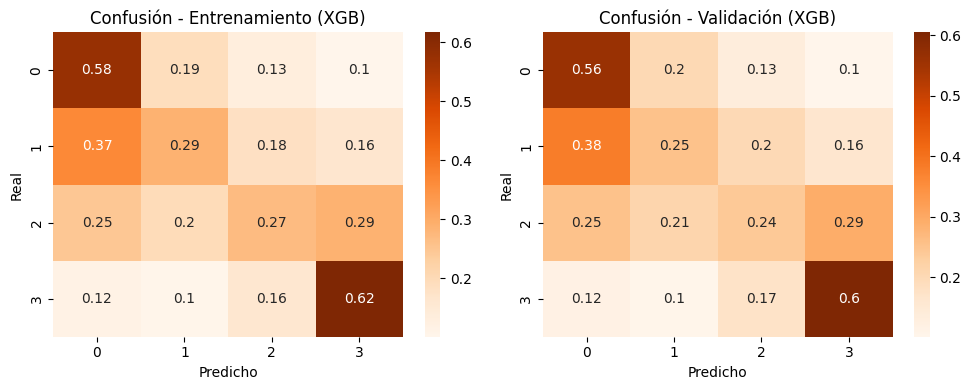

In [25]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Crear y entrenar el modelo
xgb = XGBClassifier(
    n_estimators=370,       # más árboles = más potencia
    max_depth=7,            # profundidad controlada para evitar overfitting
    learning_rate=0.03699984948204231,      # tasa de aprendizaje
    subsample=0.7824279936868144,          # reduce overfitting
    colsample_bytree=0.7599443886861021,   # usa una parte de columnas
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

xgb.fit(Xtr, ytr)

# 2. Predicciones
preds_xgb_tr = xgb.predict(Xtr)
preds_xgb_ts = xgb.predict(Xts)

# 3. Accuracy
acc_xgb_tr = accuracy_score(ytr, preds_xgb_tr)
acc_xgb_ts = accuracy_score(yts, preds_xgb_ts)

print("🚀 XGBoost - Accuracy")
print("Entrenamiento:", acc_xgb_tr)
print("Validación:  ", acc_xgb_ts)

# 4. Matrices de confusión normalizadas
cm_xgb_tr = confusion_matrix(ytr, preds_xgb_tr, normalize='true')
cm_xgb_ts = confusion_matrix(yts, preds_xgb_ts, normalize='true')

# 5. Visualización
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

sns.heatmap(cm_xgb_tr, annot=True, cmap="Oranges", ax=axs[0])
axs[0].set_title("Confusión - Entrenamiento (XGB)")
axs[0].set_ylabel("Real")
axs[0].set_xlabel("Predicho")

sns.heatmap(cm_xgb_ts, annot=True, cmap="Oranges", ax=axs[1])
axs[1].set_title("Confusión - Validación (XGB)")
axs[1].set_ylabel("Real")
axs[1].set_xlabel("Predicho")

plt.tight_layout()
plt.show()


# Preprocesado en el .test

In [26]:
# Copia del dataframe original
test = pd.read_csv("test.csv")

In [27]:
# 1. Eliminar duplicada 'FAMI_TIENEINTERNET.1' si es igual a 'FAMI_TIENEINTERNET'

if test['FAMI_TIENEINTERNET'].equals(test['FAMI_TIENEINTERNET.1']):
    test.drop(columns=['FAMI_TIENEINTERNET.1'], inplace=True)

In [28]:
# 2. Llenar valores nulos

for col in test.select_dtypes(include='number').columns:
    test[col] = test[col].fillna(test[col].median())

for col in test.select_dtypes(include='object').columns:
    test[col] = test[col].fillna(test[col].mode()[0])

In [29]:
# 3. Mapeo informativo basado en el contexto colombiano

valores_matricula_map = {
    'No pagó matrícula': 0.1,
    'Más de 7 millones': 3,
    'Entre 5.5 millones y menos de 7 millones': 2.5,
    'Entre 4 millones y menos de 5.5 millones': 2,
    'Entre 2.5 millones y menos de 4 millones': 1.5,
    'Entre 1 millón y menos de 2.5 millones': 1,
    'Entre 500 mil y menos de 1 millón': 0.5,
    'Menos de 500 mil': 0.3,
    np.nan: 0  # Imputación neutral
}

test['ESTU_VALORMATRICULAUNIVERSIDAD'] = test['ESTU_VALORMATRICULAUNIVERSIDAD'].map(valores_matricula_map)


In [30]:
# 4. Mapeo informativo basado en el contexto colombiano

departamento_map = {
    'BOGOTÁ': 3, 'ANTIOQUIA': 3, 'VALLE': 3,
    'SANTANDER': 2.5, 'ATLANTICO': 2.5, 'CUNDINAMARCA': 2.5, 'BOLIVAR': 2.5, 'CALDAS': 2.5,
    'TOLIMA': 2, 'HUILA': 2, 'RISARALDA': 2, 'QUINDIO': 2, 'BOYACA': 2, 'META': 2, 'NARIÑO': 2, 'CAUCA': 2,
    'CORDOBA': 1.5, 'NORTE SANTANDER': 1.5, 'SUCRE': 1.5, 'MAGDALENA': 1.5, 'CESAR': 1.5,
    'CHOCO': 1, 'PUTUMAYO': 1, 'GUAVIARE': 1, 'VAUPES': 1, 'AMAZONAS': 1, 'SAN ANDRES': 1,
    'ARAUCA': 1, 'CAQUETA': 1, 'CASANARE': 1, 'LA GUAJIRA': 1,
}

test['ESTU_PRGM_DEPARTAMENTO'] = test['ESTU_PRGM_DEPARTAMENTO'].map(departamento_map)



In [31]:
# 5. Mapeo informativo basado en el contexto colombiano

horas_trabajo_map = {
    '0': 4,
    'Menos de 10 horas': 3,
    'Entre 11 y 20 horas': 2,
    'Entre 21 y 30 horas': 1,
    'Más de 30 horas': 0
}
test['ESTU_HORASSEMANATRABAJA'] = test['ESTU_HORASSEMANATRABAJA'].map(horas_trabajo_map)


In [32]:
# 6. Cambiamos el tipo de estrato a un entero

test['FAMI_ESTRATOVIVIENDA'] = test['FAMI_ESTRATOVIVIENDA'].replace('Sin Estrato', 'Estrato 0')
test['FAMI_ESTRATOVIVIENDA'] = test['FAMI_ESTRATOVIVIENDA'].str.extract('Estrato (\d)').astype(int)


In [33]:
# 7.  Crear codificación one-hot para ambas columnas

test = test.copy()
test['FAMI_EDUCACIONMADRE'] = test['FAMI_EDUCACIONMADRE'].replace(['No sabe', 'No Aplica'], 'no info')
test['FAMI_EDUCACIONPADRE'] = test['FAMI_EDUCACIONPADRE'].replace(['No sabe', 'No Aplica'], 'no info')

import numpy as np
import pandas as pd

# One-hot para madre
madre_vals = sorted(test['FAMI_EDUCACIONMADRE'].dropna().unique())
madre_onehot_map = {val: np.eye(len(madre_vals))[i] for i, val in enumerate(madre_vals)}
madre_onehot_array = np.vstack([madre_onehot_map.get(v, np.zeros(len(madre_vals))) for v in test['FAMI_EDUCACIONMADRE']])
madre_df = pd.DataFrame(madre_onehot_array, columns=[f"FAMI_EDUCACIONMADRE__{v}" for v in madre_vals])

# One-hot para padre
padre_vals = sorted(test['FAMI_EDUCACIONPADRE'].dropna().unique())
padre_onehot_map = {val: np.eye(len(padre_vals))[i] for i, val in enumerate(padre_vals)}
padre_onehot_array = np.vstack([padre_onehot_map.get(v, np.zeros(len(padre_vals))) for v in test['FAMI_EDUCACIONPADRE']])
padre_df = pd.DataFrame(padre_onehot_array, columns=[f"FAMI_EDUCACIONPADRE__{v}" for v in padre_vals])

# Concatenar y eliminar columnas originales
test = pd.concat([test.reset_index(drop=True), madre_df, padre_df], axis=1)
test = test.drop(columns=['FAMI_EDUCACIONMADRE', 'FAMI_EDUCACIONPADRE'])



In [34]:
# 9. Ejemplo de mapeo por áreas (ajusta según tu criterio)

def asignar_puntaje(programa):
    if 'INGENIERIA' in programa:
        return 4.5  # Puntaje alto para ingenierías
    elif 'MEDICINA' in programa or 'ODONTOLOGIA' in programa:
        return 4.7  # Puntaje muy alto para medicina
    elif 'ADMINISTRACION' in programa:
        return 4.0  # Puntaje medio para administración
    elif 'LICENCIATURA' in programa:
        return 3.8  # Puntaje para licenciaturas
    else:
        return 3.5  # Puntaje por defecto

test['ESTU_PRGM_ACADEMICO'] = test['ESTU_PRGM_ACADEMICO'].apply(asignar_puntaje)

In [35]:
from sklearn.preprocessing import LabelEncoder

# 10. Seleccionar columnas tipo object (categóricas)
label_cols = test.select_dtypes(include='object').columns
if 'RENDIMIENTO_GLOBAL' in label_cols:
    label_cols = label_cols.drop('RENDIMIENTO_GLOBAL')

# 11. Codificar columnas categóricas
label_encoders = {}
for col in label_cols:
    le = LabelEncoder()
    test[col] = le.fit_transform(test[col].astype(str))
    label_encoders[col] = le



In [36]:
test

,ID,PERIODO,ESTU_PRGM_ACADEMICO,ESTU_PRGM_DEPARTAMENTO,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_TIENELAVADORA,FAMI_TIENEAUTOMOVIL,...,FAMI_EDUCACIONPADRE__Educación profesional incompleta,FAMI_EDUCACIONPADRE__Ninguno,FAMI_EDUCACIONPADRE__Postgrado,FAMI_EDUCACIONPADRE__Primaria completa,FAMI_EDUCACIONPADRE__Primaria incompleta,FAMI_EDUCACIONPADRE__Secundaria (Bachillerato) completa,FAMI_EDUCACIONPADRE__Secundaria (Bachillerato) incompleta,FAMI_EDUCACIONPADRE__Técnica o tecnológica completa,FAMI_EDUCACIONPADRE__Técnica o tecnológica incompleta,FAMI_EDUCACIONPADRE__no info
0,550236,20183,3.5,2.5,0.3,3,3,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,98545,20203,4.0,3.0,1.5,1,2,1,1,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,499179,20212,4.5,3.0,1.0,4,3,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,782980,20195,3.5,1.5,1.0,1,1,0,1,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,785185,20212,4.0,2.5,1.5,2,2,1,1,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296781,496981,20195,4.0,3.0,1.5,0,1,1,1,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
296782,209415,20183,3.5,2.0,1.0,4,4,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
296783,239074,20212,3.5,3.0,1.5,0,3,1,1,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
296784,963852,20195,4.5,3.0,2.5,2,3,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
X_test_data = test.drop(['ID'], axis=1)

#Preparando Submission

In [38]:
# Realizar predicciones sobre el test
y_test_pred = xgb.predict(X_test_data)


In [39]:
from sklearn.preprocessing import LabelEncoder

# Si ya tienes tu DataFrame preprocesado con la columna RENDIMIENTO_GLOBAL
target_encoder = LabelEncoder()
y = target_encoder.fit_transform(df2['RENDIMIENTO_GLOBAL'])

# Y asegúrate que X esté sincronizado
X = df2.drop(['ID', 'RENDIMIENTO_GLOBAL'], axis=1)


In [40]:
# Decodificar las predicciones
y_test_pred_labels = target_encoder.inverse_transform(y_test_pred)


In [41]:
# Diccionario inverso del que usaste originalmente
inverse_rendimiento_map = {
    0: 'bajo',
    1: 'medio-bajo',
    2: 'medio-alto',
    3: 'alto'
}

# Aplicar la transformación a las predicciones
y_test_pred_labels = [inverse_rendimiento_map[i] for i in y_test_pred]


In [42]:
import pandas as pd

# Leer el archivo test para obtener los IDs
test_df = pd.read_csv("test.csv")

# Crear el DataFrame final
submission = pd.DataFrame({
    'ID': test_df['ID'],
    'RENDIMIENTO_GLOBAL': y_test_pred_labels
})

# Guardar archivo listo para enviar
submission.to_csv("my_submission.csv", index=False)
print("✅ Archivo 'my_submission.csv' generado correctamente.")


✅ Archivo 'my_submission.csv' generado correctamente.


#Submission

In [43]:
# Paso 1: Sube tu archivo kaggle.json (usa la carpeta de la izquierda en Colab)
# Paso 2: Ejecuta esto
import os

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [44]:
!kaggle competitions submit -c udea-ai-4-eng-20251-pruebas-saber-pro-colombia -f my_submission.csv -m "Juan Andres Lopez Rivera - utilizando modelo XGBoost"


100% 4.01M/4.01M [00:00<00:00, 8.93MB/s]
Successfully submitted to UDEA/ai4eng 20251 - Pruebas Saber Pro Colombia